Do a few things:
* Remove number embedding and try a one-hot encoding
* Output categorical one hot values, per block type

What blocks to test for?
Could do one color per label. Then if condition is (0, 1, 0, 0, 0, 0, 0, 1, 0, 0), which is one and seven, it might mash up their colors.
But, output would have many channels. The MnistGPU notebook did not really have impressive results. Maybe odd even color would be better?

Ill try color per label first.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import diffusers
from tqdm import tqdm
from IPython.display import display, clear_output
from torchvision import transforms
import torchvision

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from diffusers import UNet2DModel, DDPMScheduler

import datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image

c:\Mine\Master\MyNca\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# While training, numbers are fine. These can afterwards be paired to ie. specific colors of wool + air
blockList = [
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
]

In [3]:
# Things that should only run once

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

mnist_dataset = datasets.load_dataset('mnist', split='train')

# Define a PyTorch Dataset class
class MNISTDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']

        # Convert PIL image to NumPy array
        if isinstance(image, Image.Image):  
            image = np.array(image)  # Convert to NumPy
            image.resize((32, 32))  # Resize to 32x32 # I had an error with running the unet, and changing the size fixed it.

        # Convert NumPy array to PyTorch tensor and normalize
        image = torch.tensor(image, dtype=torch.float32) / 255.0  # Normalize to [0,1]

        # Add the image as a specific channel
        multi_channel_image = torch.zeros(len(blockList), 32, 32)
        multi_channel_image[item['label'] + 1] = image
        multi_channel_image[0] = -(image - 1 )
        
        # Convert label to a tensor
        label = torch.tensor(item['label'], dtype=torch.long)
        
        return multi_channel_image, label

# Wrap the dataset
pytorch_dataset = MNISTDataset(mnist_dataset)
trainDataloader = DataLoader(pytorch_dataset, batch_size=128, shuffle=True)

noise_scheduler = DDPMScheduler(num_train_timesteps=200, beta_schedule='squaredcos_cap_v2')

Using device: cuda


In [4]:
class ClassConditionedUnet(nn.Module):
  def __init__(self, numlabels, numblocks):
    super().__init__()
    
    self.numlabels = numlabels
    self.numblocks = numblocks

    #Added an extra depth
    self.model = UNet2DModel(
        sample_size=32,          
        in_channels=numblocks + numlabels, 
        out_channels=numblocks,     
        layers_per_block=2,     
        block_out_channels=(64, 128, 128), 
        down_block_types=( 
            "DownBlock2D",    
            "DownBlock2D",   
            "AttnDownBlock2D",
        ), 
        up_block_types=(
            "AttnUpBlock2D", 
            "UpBlock2D",   
            "UpBlock2D",        
          ),
    )

  def classCondition(self, class_labels, shape):
    bs, ch, w, h = shape
    class_cond = F.one_hot(class_labels, num_classes=self.numlabels).float()  # Shape: (bs, 10)
    return class_cond.view(bs, self.numlabels, 1, 1).expand(bs, 10, w, h)  # (bs, 10, w, h)

  def forward(self, x, t, class_labels):
    bs, ch, w, h = x.shape

    class_cond = self.classCondition(class_labels, x.shape)
    # Concatenate along channel dimension
    net_input = torch.cat((x, class_cond), dim=1)  # (bs, 21, w, h)

    return self.model(net_input, t).sample # (bs, numblocks + numlabels, 28, 28)

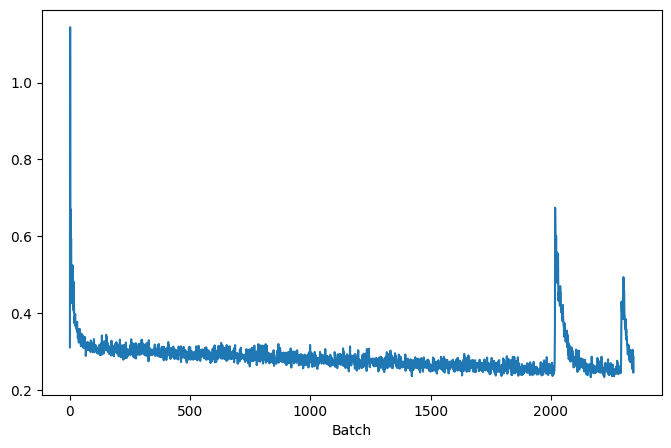

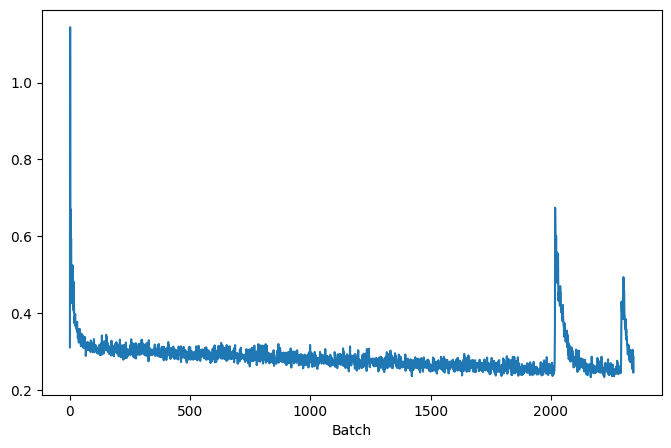

In [46]:
n_epochs = 5

#net = ClassConditionedUnet(10, len(blockList)).to(device) #10 labels
opt = torch.optim.Adam(net.parameters(), lr=1e-4) 

trainingSteps = 200

class MSEPerChannelSum(nn.Module):
    def forward(self, X_pred, X_true):
        squared_errors = (X_pred - X_true) ** 2  # Squared differences
        mean_per_channel = squared_errors.mean(dim=[0, 2, 3])  # Mean per channel
        return mean_per_channel.sum()  # Sum over all channels
    
loss_fn = nn.CrossEntropyLoss()

losses = []
fig, ax = plt.subplots(figsize=(8, 5))
display(fig)

for epoch in range(n_epochs):
    batchNum = 0
    for image, label in tqdm(trainDataloader):
        image = image.to(device) * 2 - 1 # Data on the GPU (mapped to (-1, 1))
        label = label.to(device)

        noise = torch.randn(image.shape[0], 11, image.shape[2], image.shape[3], device=device) # 11 for blocklen
        timesteps = torch.randint(0, trainingSteps - 1, (image.shape[0],), device=device).long()
        noisy_image = noise_scheduler.add_noise(image, noise, timesteps)

        pred = net(noisy_image, timesteps, label)
        #loss = loss_fn(pred, noise) # How close is the output to the noise
        loss = loss_fn(pred, noise.argmax(dim=1))

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())

    clear_output(wait=True)  
    ax.clear()
    plt.plot(losses)
    plt.xlabel('Batch')
    display(fig)

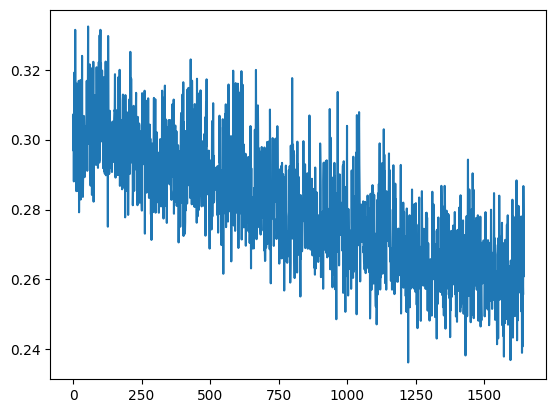

In [54]:
plt.plot(losses[200:-500])

200it [00:04, 48.05it/s]


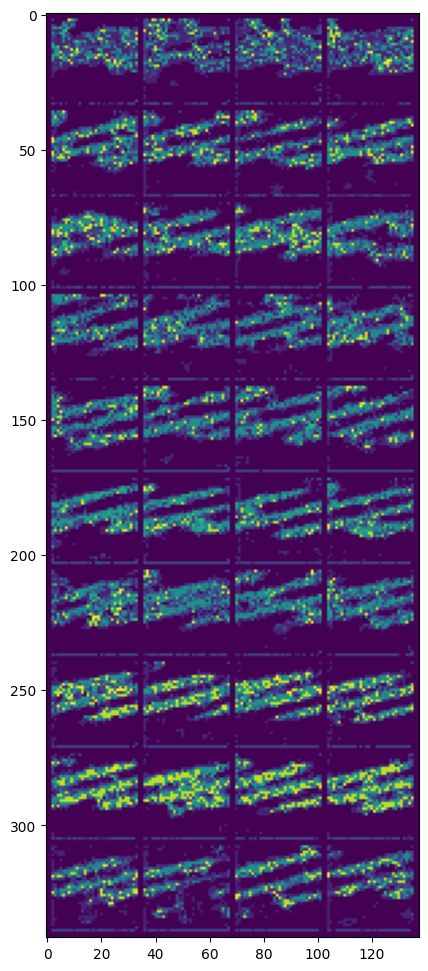

In [55]:
x = torch.randn(40, 11, 32, 32).to(device) 
labels = torch.tensor([[i]*4 for i in range(10)]).flatten().to(device)
noise_scheduler.set_timesteps(200)

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):

    with torch.no_grad():
        residual = net(x, t, labels)

    # Update sample with step
    x = noise_scheduler.step(residual, t, x).prev_sample

argmax_images = torch.argmax(x, dim=1, keepdim=True)
# Show the results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(torchvision.utils.make_grid(argmax_images.detach().cpu(), nrow=4)[0])

In [68]:
labels

tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5,
        6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9], device='cuda:0')

In [45]:
plt.imshow(x[0,11].cpu().numpy())

IndexError: index 11 is out of bounds for dimension 1 with size 11

In [5]:
# Save
#torch.save(net.state_dict(), 'blockUnet.pth')
# Load
net = ClassConditionedUnet(10, len(blockList)).to(device) 
net.load_state_dict(torch.load('blockUnet.pth'))

<All keys matched successfully>